## **MODEL LSTM**

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential, model_from_json
from tensorflow.keras.layers import Dense, LSTM, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# Load data
url = 'https://raw.githubusercontent.com/C4AnN/Models/main/Laptop%20Lens%20Model%20LSTM/Data_Barang_Keluar.csv'
store_sales = pd.read_csv(url)
store_sales['date'] = pd.to_datetime(store_sales['date'])

# Categorize data based on price
def categorize_price(price):
    if price <= 8000000:
        return 'low'
    elif 8000000 < price <= 16000000:
        return 'mid'
    else:
        return 'high'

store_sales['category'] = store_sales['price'].apply(categorize_price)

# Drop unnecessary columns
store_sales = store_sales.drop(['id_barang','name', 'price'], axis=1)

# Function to process and predict for each category
def process_category(data, category_name, window_size):
    data = data[data['category'] == category_name].drop(['category'], axis=1)
    data['date'] = data['date'].dt.to_period("M")
    monthly_sales = data.groupby('date').sum().reset_index()
    monthly_sales['date'] = monthly_sales['date'].dt.to_timestamp()

    # Calculate sales difference
    monthly_sales['sales_diff'] = monthly_sales['sales'].diff()
    monthly_sales = monthly_sales.dropna()

    # Prepare supervised data with a window size
    supervised_data = monthly_sales.drop(['date', 'sales'], axis=1)
    for i in range(1, window_size + 1):
        col_name = 'month_' + str(i)
        supervised_data[col_name] = supervised_data['sales_diff'].shift(i)
    supervised_data = supervised_data.dropna().reset_index(drop=True)

    # Split into train and test data
    train_data = supervised_data[:-24]
    test_data = supervised_data[-12:]

    # Scale the data
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler.fit(train_data)
    train_data_scaled = scaler.transform(train_data)
    test_data_scaled = scaler.transform(test_data)

    X_train, y_train = train_data_scaled[:, 1:], train_data_scaled[:, 0]
    X_test, y_test = test_data_scaled[:, 1:], test_data_scaled[:, 0]

    # Reshape input to be 3D [samples, timesteps, features]
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

    # Build LSTM model
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1], 1)))
    model.add(LSTM(200, activation='tanh', return_sequences=True))
    model.add(Dropout(0.3))
    model.add(LSTM(100, activation='tanh'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')

    # Setup callbacks
    early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

    # Train the model
    history = model.fit(X_train, y_train, epochs=100, batch_size=16, validation_data=(X_test, y_test), callbacks=[early_stop], verbose=1)

    # Save the model architecture to JSON and weights to HDF5
    model_json = model.to_json()
    with open(f'best_model_{category_name}.json', 'w') as json_file:
        json_file.write(model_json)
    model.save_weights(f'best_model_weights_{category_name}.h5')

    # Make predictions
    lstm_pre = model.predict(X_test)

    # Prepare prediction DataFrame
    sales_dates = monthly_sales['date'][-12:].reset_index(drop=True)
    predict_df = pd.DataFrame(sales_dates, columns=['date'])

    act_sales = monthly_sales['sales'][-13:].to_list()
    lstm_pre = lstm_pre.reshape(-1, 1)
    lstm_pre_test_set = np.concatenate([lstm_pre, X_test.reshape((X_test.shape[0], X_test.shape[1]))], axis=1)
    lstm_pre_test_set = scaler.inverse_transform(lstm_pre_test_set)

    result_list = []
    for index in range(0, len(lstm_pre_test_set)):
        result_list.append(lstm_pre_test_set[index][0] + act_sales[index + 1])
    lstm_pre_series = pd.Series(result_list, name="LSTM Prediction")
    predict_df = predict_df.merge(lstm_pre_series, left_index=True, right_index=True)

    # Predict next 12 months
    future_predictions = []
    last_data = supervised_data[-1:].copy()

    for _ in range(12):
        last_data_scaled = scaler.transform(last_data)
        X_last = last_data_scaled[:, 1:].reshape((1, X_train.shape[1], 1))
        next_pred = model.predict(X_last)[0, 0]

        future_pred = np.concatenate([[next_pred], last_data_scaled[0, 1:]])
        future_pred = scaler.inverse_transform([future_pred])

        future_predictions.append(future_pred[0][0] + monthly_sales['sales'].iloc[-1])

        new_row = np.append([next_pred], last_data.values[0, :-1])
        last_data = pd.DataFrame([new_row], columns=supervised_data.columns)

    future_dates = pd.date_range(start=monthly_sales['date'].iloc[-1] + pd.DateOffset(months=1), periods=12, freq='M')
    future_df = pd.DataFrame({'date': future_dates, 'LSTM Prediction': future_predictions})

    return monthly_sales, predict_df, future_df, model

# Process and predict for each category using window size of 12 months
window_size = 12  # Increase window size to consider more historical data

low_sales, low_predict_df, low_future_df, low_model = process_category(store_sales, 'low', window_size)
mid_sales, mid_predict_df, mid_future_df, mid_model = process_category(store_sales, 'mid', window_size)
high_sales, high_predict_df, high_future_df, high_model = process_category(store_sales, 'high', window_size)

# Save all models' architectures and weights
models = {'low': low_model, 'mid': mid_model, 'high': high_model}
for category, model in models.items():
    model_json = model.to_json()
    with open(f'best_model_{category}.json', 'w') as json_file:
        json_file.write(model_json)
    model.save_weights(f'best_model_weights_{category}.h5')


Epoch 1/100
2/2 [==============================] - 17s 2s/step - loss: 0.3009 - val_loss: 0.6000
Epoch 2/100
2/2 [==============================] - 0s 192ms/step - loss: 0.2833 - val_loss: 0.5883
Epoch 3/100
2/2 [==============================] - 0s 138ms/step - loss: 0.2723 - val_loss: 0.5796
Epoch 4/100
2/2 [==============================] - 0s 154ms/step - loss: 0.2627 - val_loss: 0.5799
Epoch 5/100
2/2 [==============================] - 0s 121ms/step - loss: 0.2585 - val_loss: 0.5821
Epoch 6/100
2/2 [==============================] - 0s 140ms/step - loss: 0.2625 - val_loss: 0.5708
Epoch 7/100
2/2 [==============================] - 0s 140ms/step - loss: 0.2540 - val_loss: 0.5424
Epoch 8/100
2/2 [==============================] - 0s 162ms/step - loss: 0.2398 - val_loss: 0.5240
Epoch 9/100
2/2 [==============================] - 0s 182ms/step - loss: 0.2372 - val_loss: 0.5083
Epoch 10/100
2/2 [==============================] - 0s 293ms/step - loss: 0.2302 - val_loss: 0.4941
Epoch 11/10

## **VISUALISASI DATA**

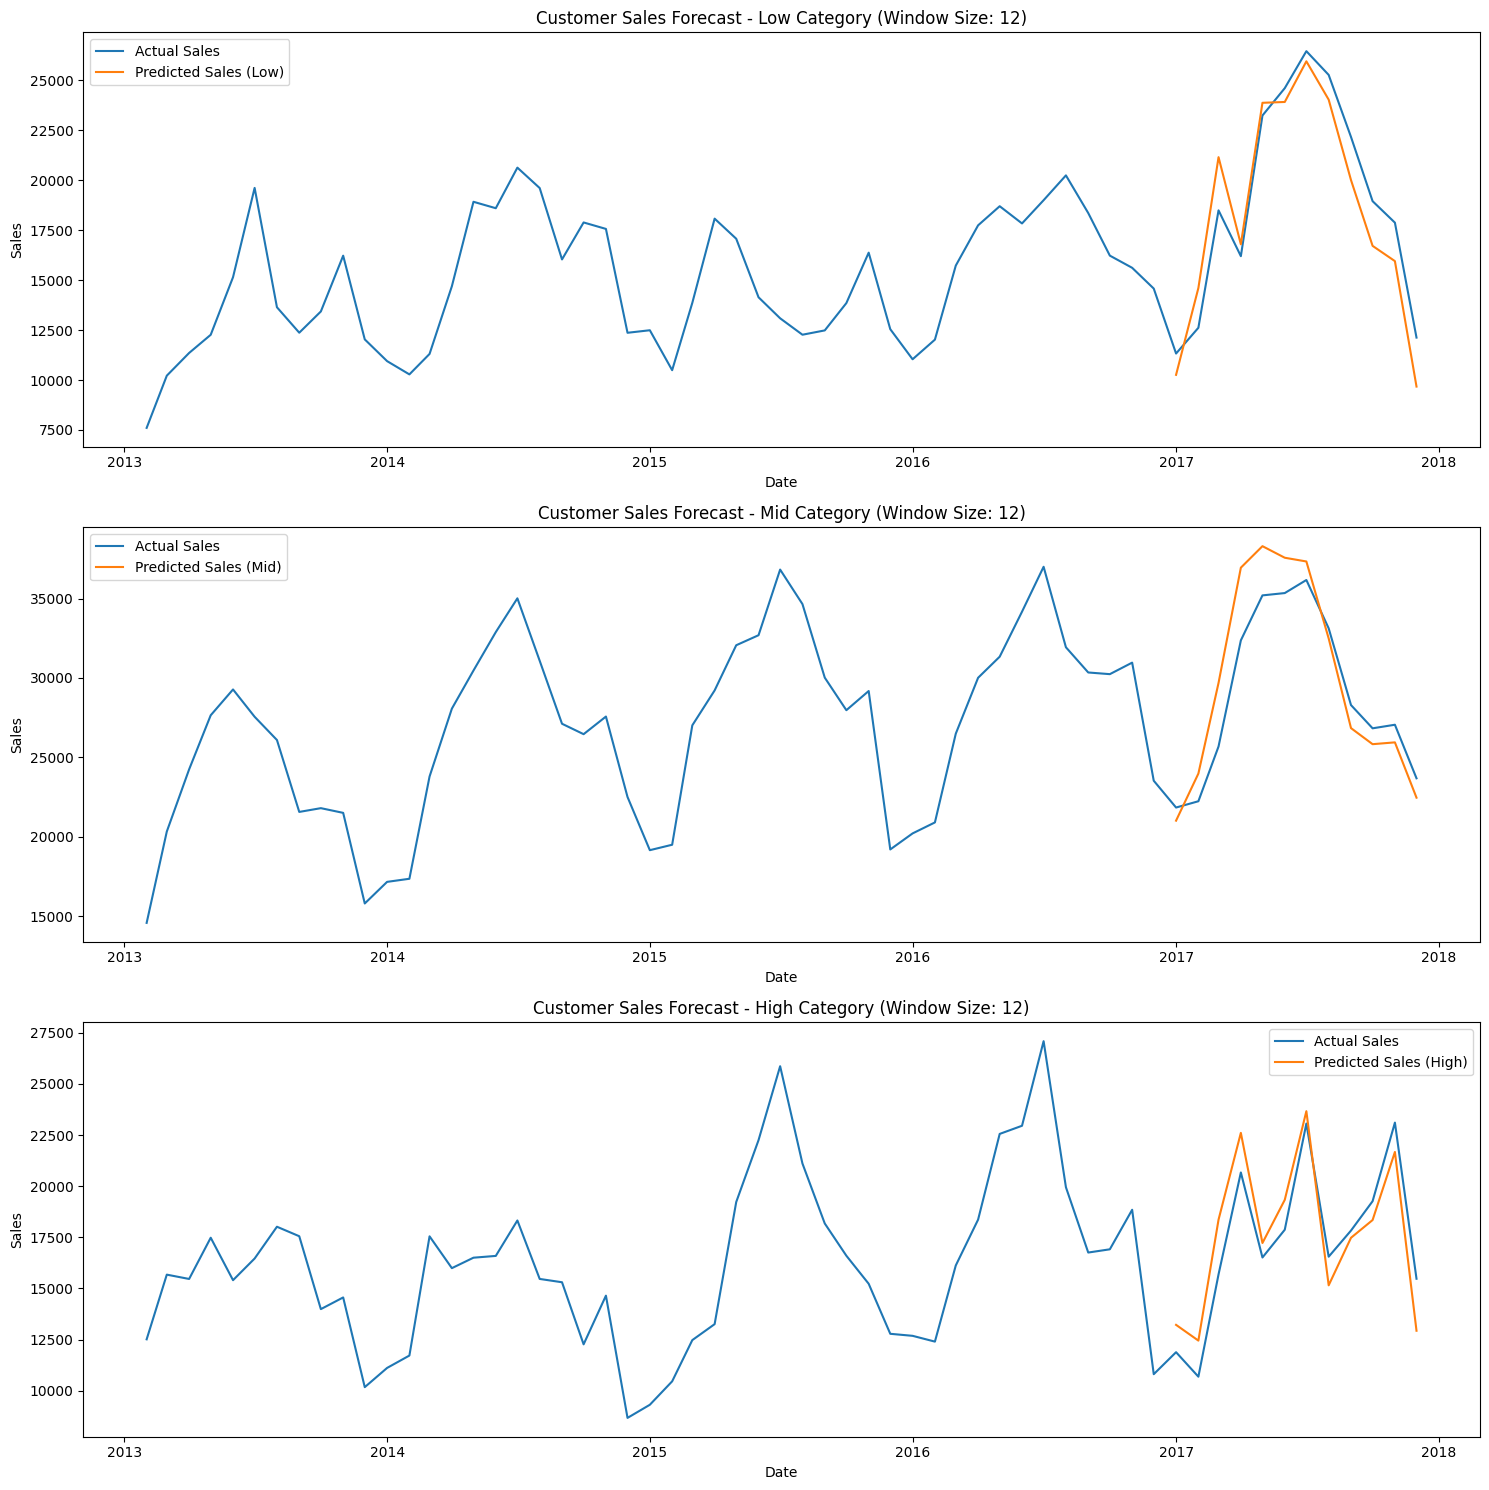

In [2]:
# Plot predictions by category
plt.figure(figsize=(15, 15))

# Low category plot
plt.subplot(3, 1, 1)
plt.plot(low_sales['date'], low_sales['sales'], label='Actual Sales')
plt.plot(low_predict_df['date'], low_predict_df['LSTM Prediction'], label='Predicted Sales (Low)')
plt.title("Customer Sales Forecast - Low Category (Window Size: 12)")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()

# Mid category plot
plt.subplot(3, 1, 2)
plt.plot(mid_sales['date'], mid_sales['sales'], label='Actual Sales')
plt.plot(mid_predict_df['date'], mid_predict_df['LSTM Prediction'], label='Predicted Sales (Mid)')
plt.title("Customer Sales Forecast - Mid Category (Window Size: 12)")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()

# High category plot
plt.subplot(3, 1, 3)
plt.plot(high_sales['date'], high_sales['sales'], label='Actual Sales')
plt.plot(high_predict_df['date'], high_predict_df['LSTM Prediction'], label='Predicted Sales (High)')
plt.title("Customer Sales Forecast - High Category (Window Size: 12)")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()

plt.tight_layout()
plt.show()


## **LOAD DATA JSON**

1/1 [==============================] - 1s 1s/step
Prediksi penjualan untuk bulan berikutnya (Low Category): 17945.633 units
Prediksi penjualan untuk bulan berikutnya (Mid Category): 24805.889 units
Prediksi penjualan untuk bulan berikutnya (High Category): 18834.227 units


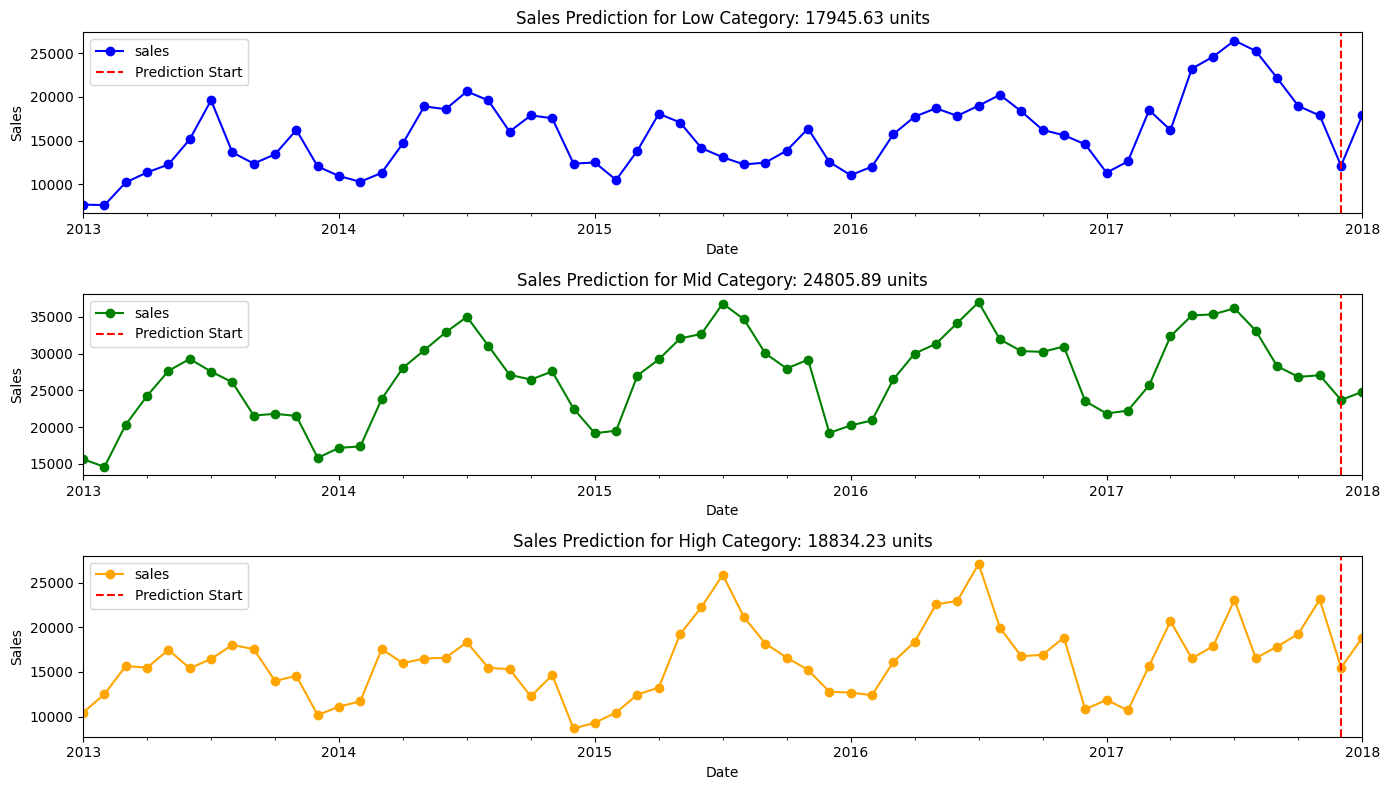

In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import model_from_json

# Load models from JSON and weights from HDF5
def load_model_from_json(json_path, weights_path):
    with open(json_path, 'r') as json_file:
        model_json = json_file.read()
    model = model_from_json(model_json)
    model.load_weights(weights_path)
    return model

loaded_model_low = load_model_from_json('best_model_low.json', 'best_model_weights_low.h5')
loaded_model_mid = load_model_from_json('best_model_mid.json', 'best_model_weights_mid.h5')
loaded_model_high = load_model_from_json('best_model_high.json', 'best_model_weights_high.h5')

# Load new data from CSV file
new_data_url = 'https://raw.githubusercontent.com/C4AnN/Models/main/Laptop%20Lens%20Model%20LSTM/Data_Barang_Keluar.csv'
new_data = pd.read_csv(new_data_url)

# Ensure 'date' column is in datetime format
new_data['date'] = pd.to_datetime(new_data['date'])

# Function to categorize price
def categorize_price(price):
    if price <= 8000000:
        return 'low'
    elif 8000000 < price <= 16000000:
        return 'mid'
    else:
        return 'high'

# Apply categorization
new_data['category'] = new_data['price'].apply(categorize_price)

# Function to make prediction for next month
def predict_next_month_sales(data, model, window_size=12):
    data['date'] = pd.to_datetime(data['date'])
    monthly_sales = data.resample('M', on='date').sum()

    # Extract sales data for the previous 11 months
    previous_11_months_sales = monthly_sales['sales'].iloc[-window_size-1:-1].values
    latest_month_sales = monthly_sales['sales'].iloc[-1]

    # Prepare input data for prediction
    input_data = np.array(previous_11_months_sales).reshape((1, window_size, 1))

    # Scale the input data
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler.fit(input_data.reshape(-1, 1))
    input_data_scaled = scaler.transform(input_data.reshape(-1, 1)).reshape((1, window_size, 1))

    # Make prediction
    predicted_sales_scaled = model.predict(input_data_scaled)

    # Inverse transform to get actual sales value
    predicted_sales_actual = scaler.inverse_transform(predicted_sales_scaled.reshape(-1, 1))

    return predicted_sales_actual[0][0]

# Filter data for each category
new_data_low = new_data[new_data['category'] == 'low'].copy()
new_data_mid = new_data[new_data['category'] == 'mid'].copy()
new_data_high = new_data[new_data['category'] == 'high'].copy()

# Predict sales for next month for each category
predicted_sales_low = predict_next_month_sales(new_data_low, loaded_model_low)
predicted_sales_mid = predict_next_month_sales(new_data_mid, loaded_model_mid)
predicted_sales_high = predict_next_month_sales(new_data_high, loaded_model_high)

# Output predictions
print("Prediksi penjualan untuk bulan berikutnya (Low Category):", predicted_sales_low, "units")
print("Prediksi penjualan untuk bulan berikutnya (Mid Category):", predicted_sales_mid, "units")
print("Prediksi penjualan untuk bulan berikutnya (High Category):", predicted_sales_high, "units")

# Prepare data for plotting
def prepare_plot_data(data, predicted_sales, category_name):
    data['date'] = pd.to_datetime(data['date'])
    monthly_sales = data.resample('M', on='date').sum()
    last_date = monthly_sales.index[-1]
    next_month_date = last_date + pd.DateOffset(months=1)

    # Create a DataFrame for plotting
    plot_data = monthly_sales['sales'].copy()
    plot_data[next_month_date] = predicted_sales

    return plot_data

# Prepare data for each category
plot_data_low = prepare_plot_data(new_data_low, predicted_sales_low, 'low')
plot_data_mid = prepare_plot_data(new_data_mid, predicted_sales_mid, 'mid')
plot_data_high = prepare_plot_data(new_data_high, predicted_sales_high, 'high')

# Plot the data
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 8))

# Plot for low category
plt.subplot(3, 1, 1)
plot_data_low.plot(marker='o', color='blue', title=f'Sales Prediction for Low Category: {predicted_sales_low:.2f} units')
plt.axvline(plot_data_low.index[-2], color='red', linestyle='--', label='Prediction Start')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Sales')

# Plot for mid category
plt.subplot(3, 1, 2)
plot_data_mid.plot(marker='o', color='green', title=f'Sales Prediction for Mid Category: {predicted_sales_mid:.2f} units')
plt.axvline(plot_data_mid.index[-2], color='red', linestyle='--', label='Prediction Start')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Sales')

# Plot for high category
plt.subplot(3, 1, 3)
plot_data_high.plot(marker='o', color='orange', title=f'Sales Prediction for High Category: {predicted_sales_high:.2f} units')
plt.axvline(plot_data_high.index[-2], color='red', linestyle='--', label='Prediction Start')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Sales')

plt.tight_layout()
plt.show()
